In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Treinando um modelo LightGBM

Modelo baseado em árvores e muito utilizado para datasets tabulares. De construção mais profunda, procura áreas no dataset com maior variância (que mais reducem loss). Tende a ser mais rápida que o XGBoost no treinamento, porẽm ẽ mais provável de resultar em overfitting em datasets pequenos e desbalanceados.

## Carregando dataset

In [2]:
# Carregar o dataset como um dataframe pandas
df = pd.read_csv('data/SouthGermanCredit.asc', sep=' ')

# Print o tamanho do dataframe para comprovar que o arquivo foi carregado corretamente
df.shape

(1000, 21)

In [3]:
# Exibir uma pequena amostra do dataset
df.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


## Pré-processamento

Como as variáveis categoricas já estão em formato numérico, não farei nenhuma transformação nelas.

In [4]:
# Separar as variáveis categóricas e contínuas
cat_var = ['laufkont', 'moral', 'verw', 'sparkont', 'beszeit', 'rate', 'famges', 'buerge', 'wohnzeit', 'verm', 'weitkred', 'wohn', 'bishkred', 'beruf', 'pers', 'telef', 'gastarb', 'kredit']
cont_var = [col for col in df.columns if col not in cat_var]

In [5]:
# Normalizar features numéricas
scaler = StandardScaler()
df[cont_var] = scaler.fit_transform(df[cont_var])
df.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,-0.240857,4,2,-0.787657,1,2,4,2,1,...,2,-1.281573,3,1,1,3,2,1,2,1
1,1,-0.987573,4,0,-0.167384,1,3,2,3,1,...,1,0.040363,3,1,2,3,1,1,2,1
2,2,-0.738668,2,9,-0.861381,2,4,2,2,1,...,1,-1.105315,3,1,1,2,2,1,2,1
3,1,-0.738668,4,0,-0.407341,1,3,3,3,1,...,1,0.304750,3,1,2,2,1,1,1,1
4,1,-0.738668,4,0,-0.389974,1,3,4,3,1,...,2,0.216621,1,2,2,2,2,1,1,1


In [6]:
# Definir features e target
X = df.drop('kredit', axis=1)
y = df['kredit']

print(X.shape, y.shape)


(1000, 20) (1000,)


In [7]:
# Dividir dataset em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Treinamento do modelo

In [8]:
# Preparar datasets para LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Parâmetros do modelo
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Treinar o modelo
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=100, callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)])


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [9]:
# Predict on the test set
y_pred = np.round(lgb_model.predict(X_test))
y_pred_proba = lgb_model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc_roc:.4f}")

#F1 Score
print(f"F1: {f1_score(y_test, y_pred):.4}")


Accuracy: 0.7650
AUC-ROC: 0.7764
F1: 0.8396


### Matriz de confusão

Exemplos do dataset de test
Com risco: 62
Sem risco: 138


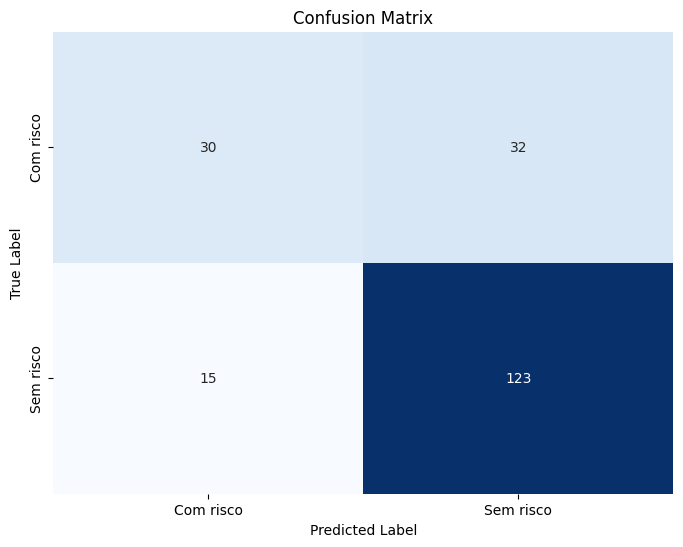

In [10]:
cm = confusion_matrix(y_test, y_pred)

print('Exemplos do dataset de test')
print('Com risco:', (y_test == 0).sum())
print('Sem risco:', (y_test == 1).sum())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Com risco', 'Sem risco'],
            yticklabels=['Com risco', 'Sem risco'])

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

### Visualização das features mais importantes

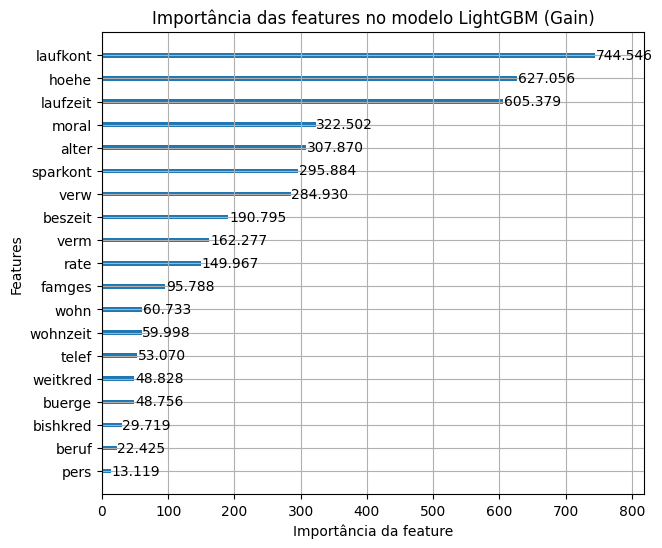

In [11]:
lgb.plot_importance(lgb_model, importance_type="gain", figsize=(7,6), title="Importância das features no modelo LightGBM (Gain)")
plt.xlabel('Importância da feature')
plt.show()